# Deep Convolutional Generative Adversarial Network

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](./images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](./images/gan2.png)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, we recommend MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.0.0'

In [5]:
# To generate GIFs
!pip install -q imageio

In [6]:
import glob
import imageio
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [7]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3

BATCH_SIZE = 32
NOISE_SIZE = 128

AUTOTUNE = tf.data.experimental.AUTOTUNE

### Load and prepare the dataset

In [8]:
def get_images_dataset(train_images_path_str):
    def _process_path(file_path):
        def __decode_img(img):
            # convert the compressed string to a 3D uint8 tensor
            img = tf.image.decode_jpeg(img, channels=3) # XXX: Working only with jpg images.
            # Use `convert_image_dtype` to convert to floats in the [0,1] range.
            img = tf.image.convert_image_dtype(img, tf.float32)
            # resize the image to the desired size.
            return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        img = __decode_img(img)
        return img

    list_ds = tf.data.Dataset.list_files(train_images_path_str)
    images_ds = list_ds.map(_process_path, num_parallel_calls=AUTOTUNE)
    return images_ds


In [9]:
def apply_augmentations(dataset, augmentation_params):
    def flip(x):
        """Flip augmentation

        Args:
            x: Image to flip

        Returns:
            Augmented image
        """
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)

        return x

    def color(x):
        """Color augmentation

        Args:
            x: Image

        Returns:
            Augmented image
        """
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
        return x

    def rotate(x):
        """Rotation augmentation

        Args:
            x: Image

        Returns:
            Augmented image
        """

        return tf.image.rot90(x, tf.random.uniform([], minval=0, maxval=4, dtype=tf.dtypes.int32))

    def zoom(x):
        """Zoom augmentation

        Args:
            x: Image

        Returns:
            Augmented image
        """

        # Generate 20 crop settings, ranging from a 1% to 20% crop.
        scales = list(np.arange(0.8, 1.0, 0.01))
        boxes = np.zeros((len(scales), 4))

        for i, scale in enumerate(scales):
            x1 = y1 = 0.5 - (0.5 * scale)
            x2 = y2 = 0.5 + (0.5 * scale)
            boxes[i] = [x1, y1, x2, y2]

        def random_crop(img):
            # Create different crops for an image
            crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(IMG_HEIGHT, IMG_WIDTH))
            # Return a random croptf.random.uniform([], 0, 1)
            return crops[tf.random.uniform([], minval=0, maxval=len(scales), dtype=tf.dtypes.int32)]

        # Only apply cropping 50% of the time
        choice = tf.random.uniform(shape=[], minval=0., maxval=1)
        return tf.cond(choice < 0.5, lambda: random_crop(x), lambda: x)

    # Apply the augmentations provided.
    supported_agumentations = {
        "flip": flip,
        "color": color,
        "zoom": zoom,
        "rotate": rotate,
    }

    prob = augmentation_params.pop("prob", 0.75)
    for cur_func_name, cur_params in augmentation_params.items():
        # TODO: params are not currently supported.
        choice = tf.random.uniform(shape=[], minval=0., maxval=1)
        dataset = dataset.map(lambda x: tf.cond(choice < prob, lambda: supported_agumentations[cur_func_name](x), lambda: x), num_parallel_calls=4)

    dataset = dataset.map(lambda x: tf.clip_by_value(x, 0, 1))
    return dataset


In [10]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000, augmentation_params=None):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Apply augmentations.
    if augmentation_params:
        ds = apply_augmentations(ds, augmentation_params)

    # Batch the dataset.
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


def show_batch(image_batch):
    plt.figure(figsize=(20, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, 8, n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')


In [11]:
train_images_path_str = "../../data/underwater_background/unsplash/unsplash_underwater_collection/*.jpg"
augmentation_params = {"prob": 0.5, "flip": 1, "color": 1, "zoom": 1, "rotate": 1}

In [12]:
images_dataset = get_images_dataset(train_images_path_str)
train_dataset = prepare_for_training(images_dataset, cache=True, shuffle_buffer_size=10000, augmentation_params=augmentation_params)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 256x256x3. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [13]:
# This is generator for images of size 256x256x3.
def make_generator_model_256():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model


In [14]:
# This is generator for images of size 256x256x3.
def make_generator_model(img_size, num_channels, noise_size):
    assert math.log(img_size, 2).is_integer() 
    init_filters = img_size * 2
    init_activation_map_size = 8

    model = tf.keras.Sequential()
    model.add(layers.Dense(init_activation_map_size*init_activation_map_size*init_filters, use_bias=False, input_shape=(noise_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((init_activation_map_size, init_activation_map_size, init_filters)))
    assert model.output_shape == (None, init_activation_map_size, init_activation_map_size, init_filters) # Note: None is the batch size

    init_filters = init_filters // 2
    model.add(layers.Conv2DTranspose(init_filters, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, init_activation_map_size, init_activation_map_size, init_filters)
    print("Adding Conv2DTranspose layer (stride-1, initial) [B, x, y, filters]: %s" % str(model.output_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    cur_activation_map_size = init_activation_map_size
    cur_filters = init_filters
    while cur_activation_map_size < (img_size // 2):
        cur_filters //= 2
        model.add(layers.Conv2DTranspose(cur_filters, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        cur_activation_map_size *= 2
        assert model.output_shape == (None, cur_activation_map_size, cur_activation_map_size, cur_filters)
        print("Adding Conv2DTranspose layer (stride-2, intermediate) [B, x, y, filters]: %s" % str(model.output_shape))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(num_channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, img_size, img_size, 3)
    print("Adding Conv2DTranspose layer (stride-2, final) [B, x, y, filters]: %s" % str(model.output_shape))

    return model


Use the (as yet untrained) generator to create an image.

In [15]:
generator = make_generator_model(IMG_HEIGHT, IMG_CHANNELS, NOISE_SIZE)

noise = tf.random.normal([1, NOISE_SIZE])
generated_image = generator(noise, training=False)

Adding Conv2DTranspose layer (stride-1, initial) [B, x, y, filters]: (None, 8, 8, 64)
Adding Conv2DTranspose layer (stride-2, intermediate) [B, x, y, filters]: (None, 16, 16, 32)
Adding Conv2DTranspose layer (stride-2, intermediate) [B, x, y, filters]: (None, 32, 32, 16)
Adding Conv2DTranspose layer (stride-2, final) [B, x, y, filters]: (None, 64, 64, 3)


In [16]:
generated_image.shape

TensorShape([1, 64, 64, 3])

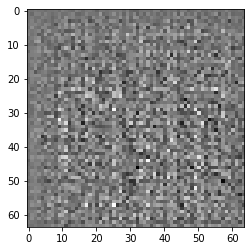

In [17]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [18]:
# This is discriminator for images of size 256x256x3.
def make_discriminator_model_256():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    assert model.output_shape == (None, 128, 128, 128)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))    

    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 16, 16, 16)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(8, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 8, 8, 8)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [19]:
# This is discriminator for images of size 256x256x3.
def make_discriminator_model(img_size, num_channels):
    init_filters = img_size // 8 
    cur_activation_map_size = img_size

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(init_filters, (5, 5), strides=(2, 2), padding='same', input_shape=[img_size, img_size, num_channels]))
    cur_activation_map_size //= 2
    assert model.output_shape == (None, cur_activation_map_size, cur_activation_map_size, init_filters)
    print("Adding Conv2D layer (stride-2, initial) [B, x, y, filters]: %s" % str(model.output_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    cur_filters = init_filters
    while cur_activation_map_size > 8:
        cur_filters *= 2
        model.add(layers.Conv2D(cur_filters, (5, 5), strides=(2, 2), padding='same'))
        cur_activation_map_size //= 2
        assert model.output_shape == (None, cur_activation_map_size, cur_activation_map_size, cur_filters)
        print("Adding Conv2D layer (stride-2, intermediate) [B, x, y, filters]: %s" % str(model.output_shape))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    print("Adding Dense layer (final) [B, fully_connected_nodes]: %s" % str(model.output_shape))

    return model


Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [20]:
discriminator = make_discriminator_model(IMG_HEIGHT, IMG_CHANNELS)
decision = discriminator(generated_image)
print (decision)

Adding Conv2D layer (stride-2, initial) [B, x, y, filters]: (None, 32, 32, 8)
Adding Conv2D layer (stride-2, intermediate) [B, x, y, filters]: (None, 16, 16, 16)
Adding Conv2D layer (stride-2, intermediate) [B, x, y, filters]: (None, 8, 8, 32)
Adding Dense layer (final) [B, fully_connected_nodes]: (None, 1)
tf.Tensor([[-7.811928e-05]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop



In [26]:
EPOCHS = 50
noise_dim = NOISE_SIZE
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [28]:
def train(dataset, epochs):
    print("Started training for epochs: %s" % epochs)
    try:
        for epoch in range(epochs):
            print("Epoch: %s" % epoch)
            start = time.time()

            for image_batch in dataset:
                train_step(image_batch)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                checkpoint.save(file_prefix = checkpoint_prefix)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    except KeyboardInterrupt:
        print("Catch KeyboardInterrupt.")
        print("Provide another KeyboardInterrupt to stop the program.")
        checkpoint.save(file_prefix = checkpoint_prefix)
        print("Saved the model to checkpoint_prefix: %s" % checkpoint_prefix)

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


**Generate and save images**



In [29]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i] * 127.5 + 127.5)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

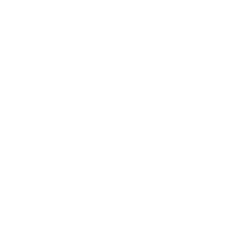

CPU times: user 46.7 s, sys: 1.53 s, total: 48.2 s
Wall time: 29.4 s


In [34]:
%%time
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [35]:
pred = generator(seed, training=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


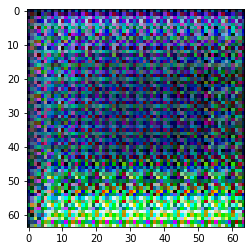

In [45]:
plt.imshow(pred[8])

## Create a GIF


In [32]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [33]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_0050.png'

Use `imageio` to create an animated gif using the images saved during training.

In [29]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [30]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset/home). To learn more about GANs we recommend the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
